In [26]:
import pandas as pd
import numpy as np
import json
import nltk
import string
import re
import sys
sys.path.append("../")
from scripts.start import iberEval, sexists
from scripts.data_utils import get_balanced_data
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.cluster import MiniBatchKMeans, KMeans, AffinityPropagation
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import homogeneity_score
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects
import matplotlib.cm as cm
##
from collections import Counter
import gensim.downloader as api
from scipy.cluster.hierarchy import dendrogram, ward, single, complete, average, weighted, centroid, median
from scipy.cluster import hierarchy
from sklearn.cluster import SpectralClustering, AgglomerativeClustering
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

In [27]:
tweets,categories,sources = get_balanced_data(500)

In [28]:
dfCat = pd.DataFrame(categories, columns=["category"]).astype('category')
catCodes = dfCat['category'].cat.codes

In [29]:
Counter(categories)

Counter({'cyberbullying': 355,
         'offensive': 500,
         'spam': 500,
         'abusive': 500,
         'hateful': 500,
         'profane': 500,
         'discredit': 500,
         'sexual_harassment': 410,
         'derailing': 29,
         'stereotype': 137,
         'dominance': 49,
         'obscene': 500,
         'insult': 500,
         'threat': 478,
         'racist': 500,
         'homophobic': 500,
         'benevolent sexism': 500,
         'hostile sexism': 500,
         'vulgar': 500})

In [30]:
def tokenize_and_lemmatize(text):
    text = re.sub("[@]\w+", "", text) # remove tags
    text = re.sub("<user>", "", text, flags=re.IGNORECASE) # remove <USER> tags
    text = re.sub("<url>", "", text, flags=re.IGNORECASE) # remove <URL> tags
    # remove punctuation
    table = text.maketrans({key: None for key in string.punctuation})
    text = text.translate(table)
    text = re.sub("(http)\w+", "", text) # remove links
    tokens = nltk.word_tokenize(text)
    filtered_tokens = []
    # Filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation).
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    #lemmas = [lemmatizer.lemmatize(token) for token in tokens]
    return filtered_tokens

In [31]:
lemmatizer = WordNetLemmatizer()
englishwords = stopwords.words('english')
englishwords.extend(["u","rt","im","em","q","na","wan","’","“","”","…"])
englishwords.extend(tokenize_and_lemmatize(" ".join(englishwords)))
# englishwords.extend(["u","rt","im","em","q","na","wan","’","“","”","…", 'arent', 'couldnt', 'didnt', 
#                      'doesnt', 'dont', 'hadnt', 'hasnt', 'havent', 'isnt', 'mightnt', 'mustnt', 'neednt', 
#                      'shant', 'shes', 'shouldnt', 'shouldve', 'thatll', 'wasnt', 'werent', 'wont', 'wouldnt', 
#               'youd', 'youll', 'youre', 'youve', 'hey', 'cause', 'you039re', '1', '2', '3',  'even', 'thats', 'could' ])
# print(englishwords)

In [32]:
for i in range(len(tweets)):
    tweets[i] = str(tweets[i])

In [33]:
tfidf_vec = TfidfVectorizer(max_df=0.95, 
                        max_features=10000,
                        min_df=10, 
                        stop_words=englishwords, 
                        tokenizer=tokenize_and_lemmatize, 
                        ngram_range=(1,1))

In [34]:
tfidf_mat = tfidf_vec.fit_transform(tweets)
tfidf_mat.shape

(7958, 1166)

In [35]:
clusters = MiniBatchKMeans(n_clusters=19, init_size=1024, batch_size=2048, random_state=20).fit_predict(tfidf_mat)
#clusters = KMeans(n_clusters=19, random_state=20).fit_predict(tfidf_mat)
Counter(clusters).most_common()

[(2, 3711),
 (1, 647),
 (10, 452),
 (16, 410),
 (11, 376),
 (17, 372),
 (13, 315),
 (5, 282),
 (12, 277),
 (0, 199),
 (6, 191),
 (4, 158),
 (15, 133),
 (14, 128),
 (18, 113),
 (7, 74),
 (9, 52),
 (3, 40),
 (8, 28)]

In [36]:
clusters2 = KMeans(n_clusters=19, random_state=20).fit_predict(tfidf_mat)
Counter(clusters2).most_common()

[(0, 3330),
 (1, 467),
 (3, 432),
 (6, 418),
 (8, 365),
 (15, 337),
 (14, 328),
 (5, 326),
 (4, 305),
 (16, 249),
 (10, 246),
 (18, 226),
 (17, 200),
 (9, 197),
 (11, 157),
 (13, 104),
 (7, 103),
 (2, 95),
 (12, 73)]

In [37]:
clusters3 = SpectralClustering(n_clusters=19, random_state=20).fit_predict(tfidf_mat)
Counter(clusters2).most_common()

[(0, 3330),
 (1, 467),
 (3, 432),
 (6, 418),
 (8, 365),
 (15, 337),
 (14, 328),
 (5, 326),
 (4, 305),
 (16, 249),
 (10, 246),
 (18, 226),
 (17, 200),
 (9, 197),
 (11, 157),
 (13, 104),
 (7, 103),
 (2, 95),
 (12, 73)]

In [38]:
def plot_lda(data, labels, defLabels=None, plotlabels=None):
    lda = LDA(n_components=2).fit_transform(data.todense(), y=labels)
    label_subset = labels
    f, ax = plt.subplots(1, 1, figsize=(6, 6))
    pts2 = ax.scatter(lda[:, 0], lda[:, 1], c=label_subset, cmap="jet", alpha=0.5)
    legendItems = pts2.legend_elements(num=None)[0]

    plotLegendItems = []
    for ix in range(len(plotlabels)):
        ixs = np.where(defLabels == plotlabels[ix])[0][0]
        plotLegendItems.append(legendItems[ixs])
    
    ax.legend(plotLegendItems, plotlabels, loc='lower left')
    return ax, f

In [39]:

def plot_tsne(data, labels, defLabels=None, plotlabels=None):
    max_label = max(labels)
    #max_items = np.random.choice(range(data.shape[0]), size=5000, replace=False)
    pca = PCA(n_components=2, random_state=2).fit_transform(data.todense())
    tsne = TSNE(random_state=2).fit_transform(PCA(n_components=50, random_state=2).fit_transform(data.todense()))
    
    #idx = np.random.choice(range(pca.shape[0]), size=3000, replace=False)
    label_subset = labels#[max_items]
    #label_subset = labels[idx]
    f, ax = plt.subplots(1, 1, figsize=(16, 7))
    pts2 = ax.scatter(tsne[:, 0], tsne[:, 1], c=label_subset, cmap="jet", alpha=0.5)
    #ax.set_title('TSNE Cluster Plot')

    # for each category, plot its annotation in centroid
    #if defLabels is not None:
    #    for ix in range(len(np.unique(labels))):
    #        if defLabels[ix] in plotlabels:
    #            ixs = np.where(labels == np.unique(labels)[ix])
    #            ax.annotate(defLabels[ix].upper(), alpha=1.0, xy=(np.median(tsne[ixs,0]), 
    #            np.median(tsne[ixs,1])), xytext=(0, 0), textcoords='offset points', ha='center', va='center', size=15)

    if defLabels is None:
        ax.legend(*pts2.legend_elements(num=None), loc='lower right')
    else:
        ax.legend(pts2.legend_elements(num=None)[0], defLabels, loc='lower right')

    return ax, f

In [40]:
def plot_tsne_pca(data, labels,defLabels=None):
    max_label = max(labels)
    max_items = np.random.choice(range(data.shape[0]), size=5000, replace=False)

    pca = PCA(n_components=2).fit_transform(data.todense())
    tsne = TSNE().fit_transform(PCA(n_components=50).fit_transform(data.todense()))
    
    #idx = np.random.choice(range(pca.shape[0]), size=3000, replace=False)
    label_subset = labels#[max_items]
    #label_subset = labels[idx]


    f, ax = plt.subplots(1, 2, figsize=(26, 11))
    
    pts = ax[0].scatter(pca[:, 0], pca[:, 1], c=label_subset, cmap="jet")
    #print(pts.legend_elements()[0])
    ax[0].set_title('PCA Cluster Plot')
    #print(*pts.legend_elements())
    #print(tsne[:, 0].shape)
    pts2 = ax[1].scatter(tsne[:, 0], tsne[:, 1], c=label_subset, cmap="jet")
    ax[1].set_title('TSNE Cluster Plot')
    if defLabels is None:
        ax[0].legend(*pts.legend_elements(num=None))
        ax[1].legend(*pts2.legend_elements(num=None))
    else:
        ax[0].legend(pts.legend_elements(num=None)[0], defLabels)
        ax[1].legend(pts2.legend_elements(num=None)[0], defLabels)

In [41]:
def plot_tsne_lda(data, labels, defLabels=None):
    max_label = max(labels)
    max_items = np.random.choice(range(data.shape[0]), size=5000, replace=False)

    lda = LDA(n_components=2).fit_transform(data.todense(), y=labels)
    tsne = TSNE().fit_transform(PCA(n_components=50).fit_transform(data.todense()))
    
    #idx = np.random.choice(range(lda.shape[0]), size=3000, replace=False)
    label_subset = labels#[max_items]
    #label_subset = labels[idx]


    f, ax = plt.subplots(1, 2, figsize=(26, 11))
    
    pts = ax[0].scatter(lda[:, 0], lda[:, 1], c=label_subset, cmap="jet", alpha=0.5)
    #print(pts.legend_elements()[0])
    ax[0].set_title('LDA Cluster Plot')
    #print(*pts.legend_elements())
    #print(tsne[:, 0].shape)
    pts2 = ax[1].scatter(tsne[:, 0], tsne[:, 1], c=label_subset, cmap="jet")
    ax[1].set_title('TSNE Cluster Plot')
    if defLabels is None:
        ax[0].legend(*pts.legend_elements(num=None))
        ax[1].legend(*pts2.legend_elements(num=None))
    else:
        ax[0].legend(pts.legend_elements(num=None)[0], defLabels)
        ax[1].legend(pts2.legend_elements(num=None)[0], defLabels)

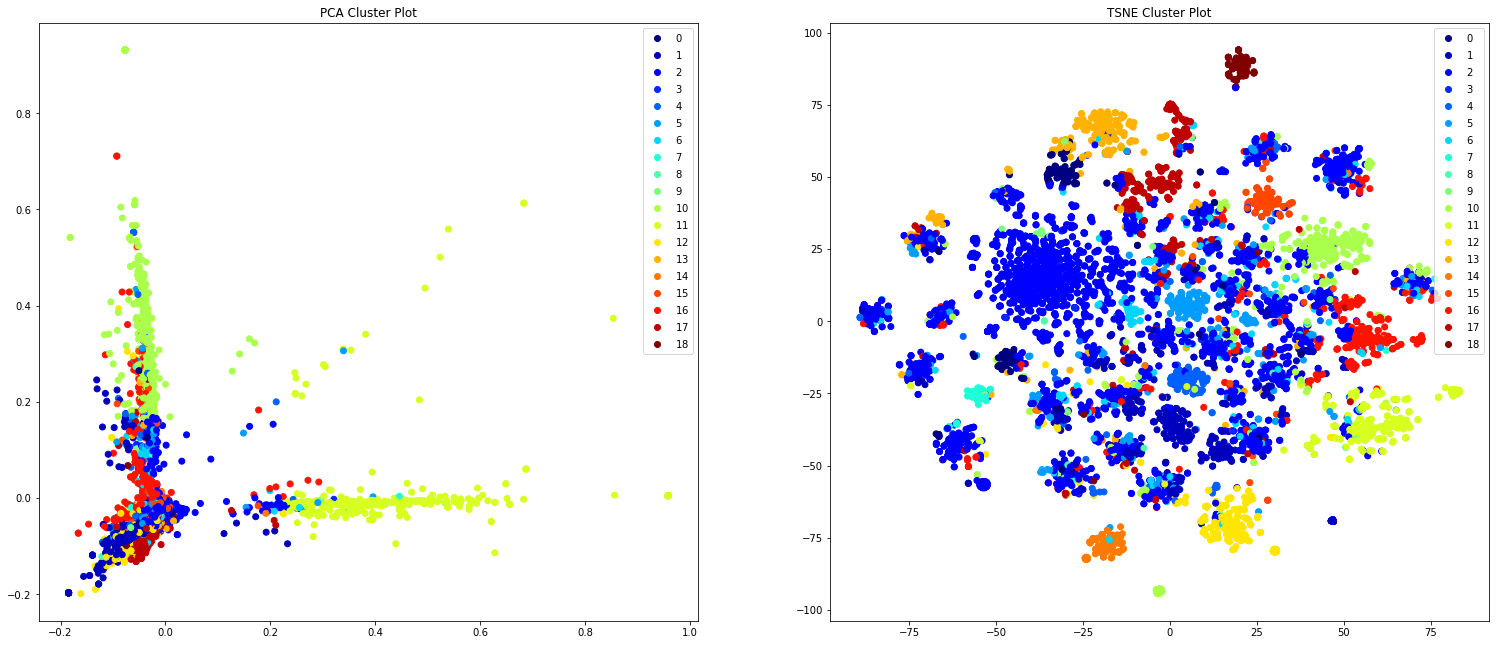

In [42]:
plot_tsne_pca(tfidf_mat, clusters)

(<AxesSubplot:>, <Figure size 432x432 with 1 Axes>)

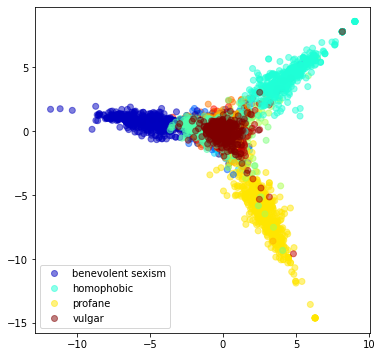

In [43]:
plot_lda(tfidf_mat, catCodes, np.unique(categories), ["benevolent sexism", "homophobic", "profane", "vulgar"])

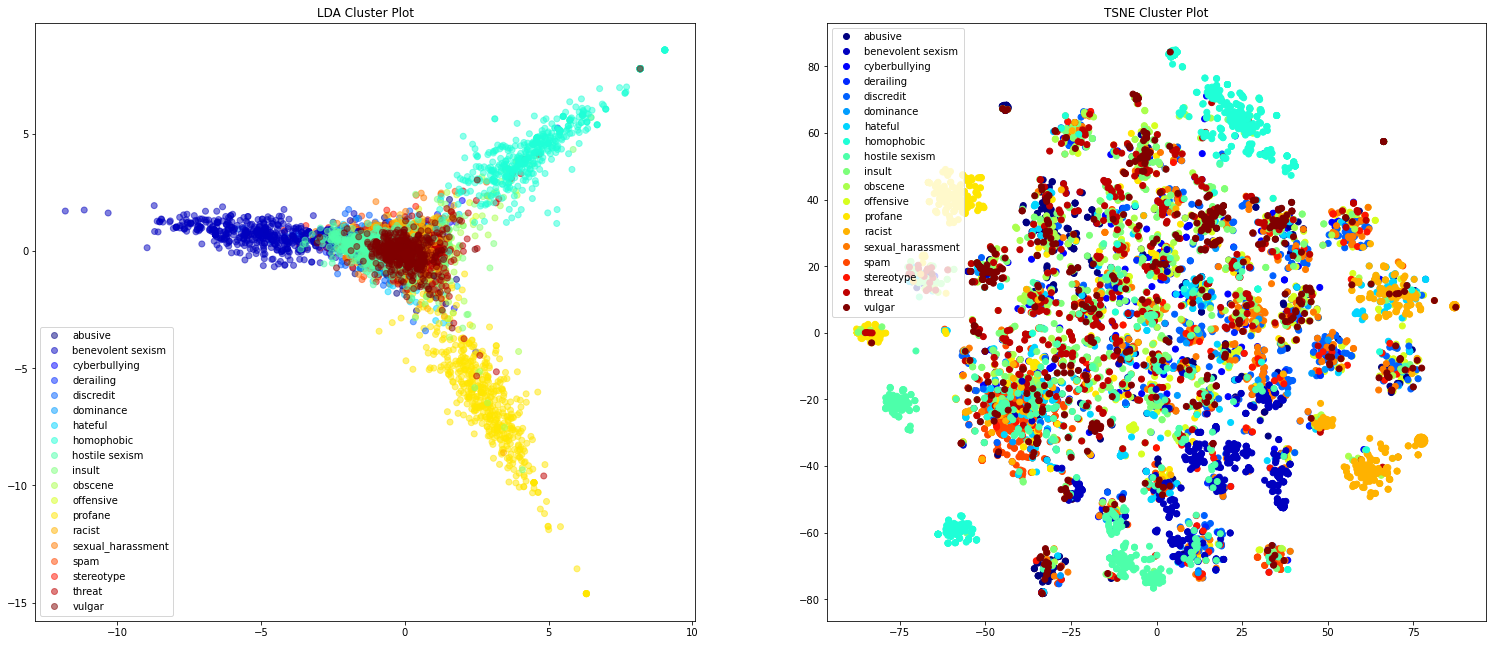

In [44]:
plot_tsne_lda(tfidf_mat, catCodes, np.unique(categories))

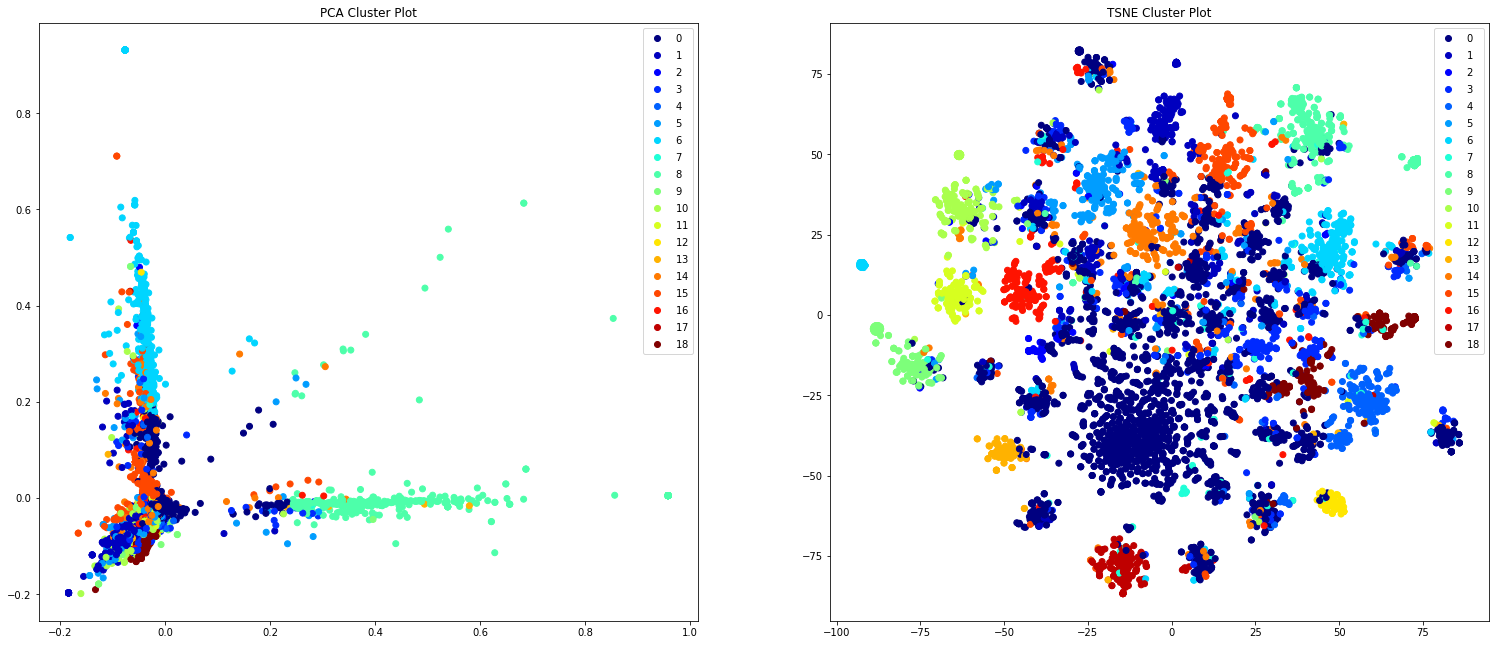

In [45]:
plot_tsne_pca(tfidf_mat, clusters2)

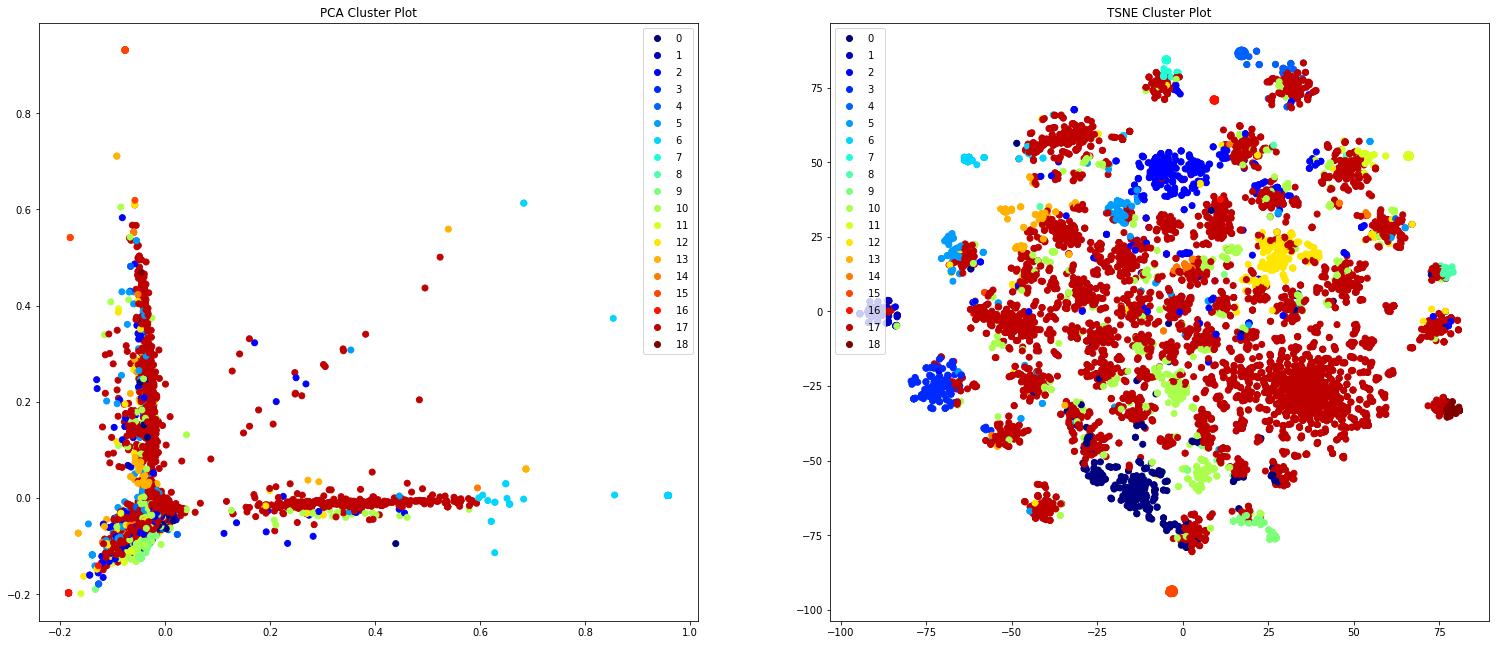

In [46]:
plot_tsne_pca(tfidf_mat, clusters3)

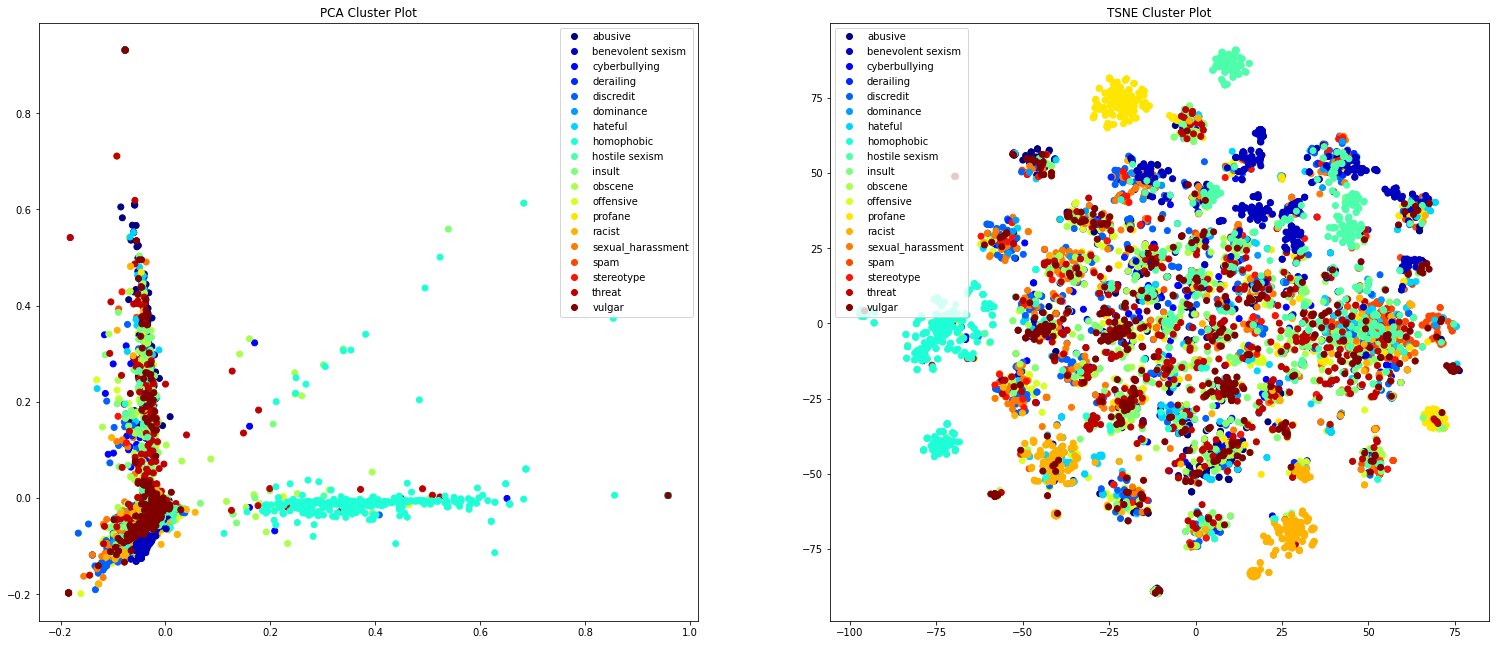

In [47]:
plot_tsne_pca(tfidf_mat, catCodes, np.unique(categories))

## Grouping documents by category & using TFIDF and word2vec embeddings

In [48]:
uniquecategories = np.unique(categories)
tweetsNP = np.array(tweets)
tweetsByCategory = []
for i in range(len(uniquecategories)):
    indices = np.where(np.array(categories) == uniquecategories[i])
    tweetsByCategory.append(" ".join(list(tweetsNP[indices])))
uniquecategories = np.array(["benevolent" if c == "benevolent sexism" else "hostile" if c == 'hostile sexism'
                             else "harassment" if c == 'sexual_harassment' else c for c in uniquecategories])

In [49]:
tfidf_vec3 = TfidfVectorizer(max_df=1.0,
                        max_features=10000,
                        min_df=3, 
                        stop_words=englishwords, 
                        tokenizer=tokenize_and_lemmatize, 
                        ngram_range=(1,1))

In [50]:
tfidf_mat3 = tfidf_vec3.fit_transform(tweetsByCategory)
tfidf_mat3.shape

(19, 3250)

In [51]:
documentVectors = tfidf_mat3.todense()
print(documentVectors.shape)

(19, 3250)


In [52]:
similarities = documentVectors.dot(documentVectors.T)

In [53]:
ap = AffinityPropagation(affinity='precomputed', damping=0.51).fit(similarities)

C:\Users\Jurij\anaconda3\envs\nlp\lib\site-packages\sklearn\cluster\_affinity_propagation.py:148: FutureWarning: 'random_state' has been introduced in 0.23. It will be set to None starting from 1.0 (renaming of 0.25) which means that results will differ at every function call. Set 'random_state' to None to silence this warning, or to 0 to keep the behavior of versions <0.23.
  warnings.warn(


In [54]:
ixs = np.argsort(ap.labels_)
ixs

array([ 1, 16,  3,  4,  5, 11, 14,  7,  8,  9, 17, 10, 13, 15,  0,  6,  2,
       12, 18], dtype=int64)

In [55]:
simsorted = similarities[ixs,:][:,ixs]
uniquecatssorted = uniquecategories[ixs]

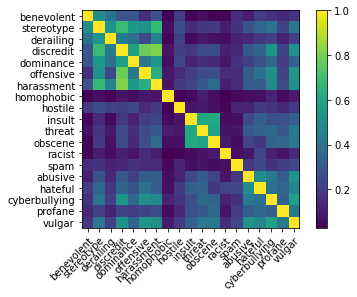

In [56]:
fig, ax = plt.subplots()
heatmap = plt.imshow(simsorted)
ax.set_yticks(np.arange(len(uniquecatssorted)))
ax.set_yticklabels(uniquecatssorted)
ax.set_xticks(np.arange(len(uniquecatssorted)))
ax.set_xticklabels(uniquecatssorted)
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")
plt.colorbar(heatmap)
plt.show()

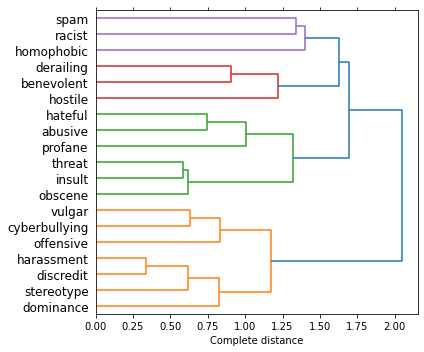

In [57]:
dists1 = 1-simsorted
# %matplotlib inline

# hierarchical clustering:

fig, ax = plt.subplots(figsize=(6, 5)) # set size

linkg = hierarchy.linkage(dists1, 'complete') # ward, single, average, weighted, centroid, median, complete
ax = dendrogram(linkg, orientation="right", labels=uniquecatssorted);

plt.tick_params(\
    axis= 'x',         # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom='off',      # ticks along the bottom edge are off
    top='off',         # ticks along the top edge are off
    labelbottom='off')

plt.tight_layout() #show plot with tight layout
plt.xlabel("Complete distance")
plt.tight_layout()

# Uncomment the below to show or save the plot.
plt.show()
#plt.savefig('ward_clusters.png', dpi=200) #save figure as ward_clusters
# plt.close()

## Word2vec average document representations

In [58]:
import gensim.downloader as api

In [59]:
word2vec = api.load('word2vec-google-news-300')

In [60]:
documentVectors = np.zeros((300,19))
npFeatures = np.array(tfidf_vec3.get_feature_names())
for i in range(19):
    row = np.array(tfidf_mat3.getrow(i).todense()).flatten()
    indices = row.argsort()[::-1][:30]
    # print(uniquecategories[i], npFeatures[indices])
    for ix in indices:
        if npFeatures[ix] in word2vec:
            documentVectors[:,i] += word2vec[npFeatures[ix]] * row[ix]

In [61]:
documentVectors = documentVectors / np.linalg.norm(documentVectors, axis=0)

In [62]:
similarities = documentVectors.T.dot(documentVectors)

In [63]:
ap = AffinityPropagation(affinity='precomputed', damping=0.51).fit(similarities)
ixs = np.argsort(ap.labels_)
simsorted = similarities[ixs,:][:,ixs]
uniquecatssorted = uniquecategories[ixs]

C:\Users\Jurij\anaconda3\envs\nlp\lib\site-packages\sklearn\cluster\_affinity_propagation.py:148: FutureWarning: 'random_state' has been introduced in 0.23. It will be set to None starting from 1.0 (renaming of 0.25) which means that results will differ at every function call. Set 'random_state' to None to silence this warning, or to 0 to keep the behavior of versions <0.23.
  warnings.warn(


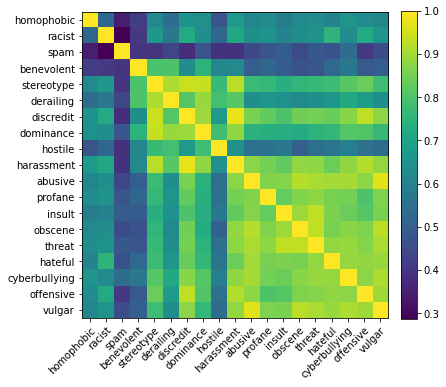

In [64]:
fig, ax = plt.subplots()
heatmap = plt.imshow(simsorted)
fig.set_size_inches(6, 6)
ax.set_yticks(np.arange(len(uniquecatssorted)))
ax.set_yticklabels(uniquecatssorted)
ax.set_xticks(np.arange(len(uniquecatssorted)))
ax.set_xticklabels(uniquecatssorted)
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")
plt.colorbar(heatmap,fraction=0.046, pad=0.04)
plt.show()

In [65]:
dist = 1 - simsorted

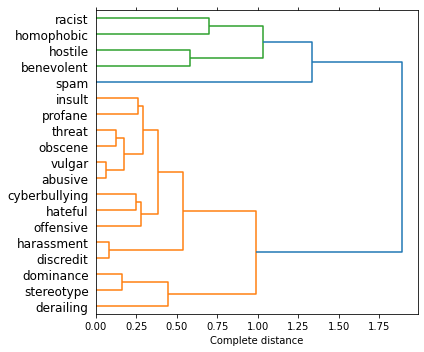

In [66]:
# hierarchical clustering:
fig, ax = plt.subplots(figsize=(6, 5)) # set size

linkg = hierarchy.linkage(dist, 'complete') # ward, single, average, weighted, centroid, median, complete
ax = dendrogram(linkg, orientation="right", labels=uniquecatssorted);

plt.tick_params(\
    axis= 'x',         # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom='off',      # ticks along the bottom edge are off
    top='off')         # ticks along the top edge are off )

plt.tight_layout() #show plot with tight layout
plt.xlabel("Complete distance")
plt.tight_layout()

# Uncomment the below to show or save the plot.
plt.show()
#plt.savefig('ward_clusters.png', dpi=200) #save figure as ward_clusters
# plt.close()